# MC of a Compton interaction: part I

## Introduction

In this excercise session we will run a monte carlo simulation of a **single compton interaction**. An incoming x-ray of energy $E$ wil impinge a slab of a material with thickness $T$ atomic number $Z$. After a certain distance $zc$, the photon undergoes a compton interaction and is scattered under a certain solid angle $\Omega$. After this single interaction, the photon will freely propagate until it reaches the detector and is measured. 

This excercise consists out of different steps.
1. Calculate the **distance travelled** before a compton interaction takes place. 
2. Determine **the angle** under which the photon will be scattered using the Klein-Nishina cross-section.
3. Determine if the scattered photon will end up on the detector and if so in which pixel
4. Put everything together. 

Step 1 and 2: are done in this workbook (part1). Step 3 and step 4 are done in part2.


Below you see a graphical description of the problem. We assume the following:
1. The x-rays originate from a pencil beam and propagate in direction d= [0,0,1] towards the detector.
2. The material plate has a finite thickness T, but extends to infinity in the x and y direction. 
3. There will only be one compton interaction.

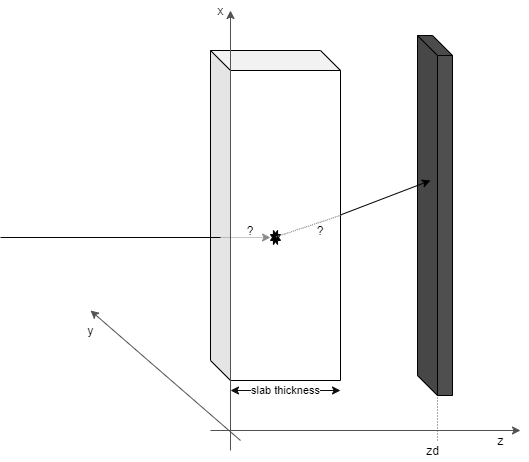


### packages

In [ ]:
import numpy as np
import sympy
import matplotlib.pyplot as plt

## STEP 1: Distance travelled before a compton interaction
In the first step we need to sample the probability for a compton interaction to happen. This problem is described in your handbook on page 364. The relative number of x-rays that will compton scatter after some distance $dc$ in a material is given by:
$$ \frac{I}{I_0} = \exp(-\mu_c \cdot dc) $$
The probability density function for a photon to interact via the Compton process between $s+ds$ is then given by:
$$ f(s) = \mu \cdot \exp(-\mu s) $$
This is a common distribution and you can use section 8.2.4 to determine for a random value $\xi$ what the distance before interaction is. 
In this excercise, the cross-section for interaction will be taken from the NIST database (https://physics.nist.gov/cgi-bin/Xcom/xcom2). 
- The cross-sections for calcium (Z=20) are already downloaded and put in the excercise folder. The density of calcium is 1.63 g/cm³.

In [ ]:
# DO NOT CHANGE

def get_compton_crosssection(energy_keV, atomic_number, density):
    """reads the nist file, interpolates to energy = energy_keV and return the associated compton cross section
    energy_keV = energy [keV]
    atomic number = Z value
    density = density in [g/cm³]
    returns: cross section [1/cm]
    """ 
    if energy_keV< 1:
        print('Energy should be larger or equal to 1 keV')
        return 0
    # read in NIST DATA
    input = np.loadtxt('CrossSection_Compton_Z%i.txt' %atomic_number, skiprows =3)
    # set energy in MeV
    energy_MeV = energy_keV/1000
    # interpolate
    cross_section = np.interp(energy_MeV, input[:,0], input[:,1])*density
    return cross_section

mu = get_compton_crosssection(30,20,1.63)
print('The cross section is ', mu)

**Exercise 1a:** Now implement ***sampling from common distributions method*** to sample the probability for interaction. Compleet the function below. 

In [ ]:
# COMPLETE THIS SCRIPT
def distance_travelled_before_interaction(mu):
    """ 
    input: cross section for compton scatter [1/cm]
    returns: sampled distance travelled before interaction [cm]
    """
    xi = np.random.random(1)  # one random value between [0,1]
    s = ...  # COMPLETE
    return s

**Exercise 1b:** Now we will use the function you have just created to see which distances a photon travels before encountering a Compton interaction. 
1. Complete the script below.
2. Repeat the sampling N times and plot the result in a histogram. Is this what you would expect? Run the script for N =50, N=100, N=1000 and N=10000.
3. What is the average and std of the distance travelled? How should they relate to mu?

In [ ]:
# COMPLETE THIS SCRIPT
mu = get_compton_crosssection(30,20,1.63)
N = 10000
distances = np.ones(N) * (-1)  # an array holding the different distances, for now filled with unrealistic (-1) values
for i in range(N):
    distances[i] = ...   # COMPLETE
    
plt.hist(distances, bins=100)
plt.xlabel('distance before interaction cm')
plt.show()

avg_distance = np.mean(distances)
std_distance = np.std(distances)
expected_average = ...  # COMPLETE
expected_std = ...    # COMPLETE
print('Average distance travelled =', np.round(avg_distance,2), '+/-', np.round(std_distance,2))
print('expected average =', np.round(expected_average,2), '+/-', np.round(expected_std,2))


**Excercise 1c:** The slab has a finite thickness of 10 cm. This means that some photons will pass the slab without having an interaction. In this project we are not interested in those primary photons. Adjust the script above to kick those x-rays out.

Python tip: you can use 'distances = distances[distances!=A]' to remove all values A out of an array.

In [ ]:
# COMPLETE THIS SCRIPT

N = 1000
distances = np.ones(N) * (-1)  # an array holding the different distances, for now filled with unrealistic (-1) values
thickness_slab = 10
for i in range(N):  # COMPLETE
...
    
plt.hist(distances, bins=100)
plt.xlabel('distance before interaction cm')
plt.show()

### Step 2: The scatter angle

#### 2.1 introduction

After the compton interaction the photon will be scattered. In this step the probability distribution of the scatter angle will be sampled. The Klein-Nishina cross-section gives the probability to be scattered in a certain solid angle. The equation can be written as a function of $\theta$, the scatter angle where $\theta=0$ equals forward scatter and $\theta=\pi$ equals backward scatter. More commonly the equation is written as a function of energy. Due to conservation of energy and conservation of momentum, the scatter angle $\theta$  is related to the energy transfer. 

$$ \frac{\partial \sigma}{ \partial \Omega} = Z \frac{r_e^2}{2}\left(\frac{Ec}{E}\right)^2 \left(\frac{Ec}{E} + \frac{E}{Ec}-\sin^2\theta\right)$$ 

with $E$ the energy of the incoming photon and $Ec$  the energy of the scattered photon. The ratio of these energies is directly related to the scatter angle. This quantity is refered to as $\tau$:

$$ \tau \equiv \frac{Ec}{E} = \frac{1}{1 + \kappa (1-\cos \theta)} $$

with $\kappa = E/m_e c^2$, the ratio of the energy of the incoming photon and the rest energy of the electron. 

Baro et al. wrote an algorithm to sample the Klein-Nishina PDF. In order to apply it, it should be rewritten as:

$$ PDF = \frac{1}{\tau^2} +  \frac{\kappa^2 -2\kappa -2}{\tau} + (2\kappa +1) + \kappa^2\tau$$ 

with the minimal and maximal value of $\tau$
$$ \tau_{min} = \frac{1}{1+2\kappa} $$ and $$ \tau_{max}=1 $$

#### 2.2 the pdf
Sampling the pdf above is not straightforward. Mainly, because there are 2 unkowns in the function ($\tau$ and $\kappa$). The equation can be simplified by fixing the energy of the incoming photon and setting the value of $\kappa$ in the pdf.

Below first the equation of the pdf is given as a symbolic equation, kappa calculated and a a PDF 'pdf_fixk' calculated for a given energy ($E=120$ keV). At the end the pdf(E=120kEV) is plotted.

In [ ]:
# DO NOT CHANGE
"""A. Define symbols and construct a the pdf as a sympy equation
"""
tau_s = sympy.symbols('tau', real=True, positive=True) # ratio of the scattered and incoming energy Ec/E
k_s = sympy.symbols('kappa', real=True, positive=True) # ratio of the incoming energy and the electron rest energy

pdf_symp = 1/tau_s**2 + (k_s**2-2*k_s-2)/tau_s + (2*k_s+1) + k_s**2*tau_s
pdf_symp  # displays the symbolic formula

In [ ]:
# DO NOT CHANGE
''' B. Kappa
'''
mec2 = 5.11e5 # rest energy electron eV
kappa = lambda E: E * 1000/mec2  # a function that calculates kappa from an energy E in keV

''' C. Simplify the pdf by evaluating it for a certain incoming energy E
'''
incoming_energy_keV = 1000
pdf_symp_kfix = pdf_symp.subs(k_s, kappa(incoming_energy_keV))  # subsitute 'k_s' by a value 
pdf_symp_kfix # displays the symbolic formula

In [ ]:
# DO NOT CHANGE
''' D. plot the pdf at a fixed kappa value as function of tau
'''
min_tau = 1/(1+2*kappa(incoming_energy_keV))
max_tau = 1
tau_array = np.linspace(min_tau, max_tau, 1000)
pdf = sympy.lambdify([tau_s], pdf_symp_kfix) # transforms the sympy expression to a python function 
plt.plot(tau_array, pdf(tau_array))
plt.show()

**excercise 2a:** We will sample the pdf plotted above using the ***rejection method*** described in the book in 8.2.3. The pdf as it is, is not ready to be used. Apply some transformations such that it becomes usable. 

Python tip: The transforming is the easiest in sympy. You can use the common symbols (\*,/,+,-) on pdf_symp. To evaluate the sympy expression: use the sympy.subs(x,x_val) method (also used above to set a value for $\kappa$). All x's will be replaced with x_val. Once ready, use sympy.lambdify to transform the sympy expression to a python function (like also done above). 

In [ ]:
# COMPLETE THIS SCRIPT
""" E. Transform the pdf
"""
...
pdf = ...
plt.plot(tau_array, pdf(tau_array))
plt.show()

**excercise 2b**: Next, we will sample the pdf using the rejection sampling method.
1. Complete the 'Rejection_sampling' function
2. Run 5000 times and plot the histograms of the selected $\tau$ values. 
3. Test the effect of energy of the incoming photon on the (sampled) pdf. Try E=10keV, 30keV, 120keV, 1MeV and 10 MeV. You can change the energy in step B. Do not forget to rerun all steps inbetween. 
If your rejection algorithm is working well, the histogram should approximate the shape of pdf(tau) in the previous step.

In [ ]:
# COMPLETE THIS SCRIPT
''' F. The rejection sampling method
'''
def rejection_sampling(min_x, max_x, pdf):
    """ 
    input min, max and the psd function
    return: [boolean(False/true) -, sample (x)]
    """
    [xi1, xi2] = ...   # COMPLETE
    ...    # COMPLETE
    if ...:  # Accept         # COMPLETE
        return True, x
    else:  # Reject 
        return False, x
    
# DO NOT CHANGE
N = 50000
tau_out = np.ones(N) * (2) # an array holding the different distances, for now filled with unrealistic values
for i in range(N):
    res, x = rejection_sampling(min_tau, max_tau, pdf)
    if res:  # accepted
        tau_out[i] = x
tau_out = tau_out[tau_out!=2]
    
plt.hist(tau_out, bins=100)
plt.xlabel('tau')
plt.show()

#### 2.3 the scatter angles
The sampling method above resulted in values of $\tau$, but in which direction is it scattered? There are two angles defining the direction of propagation $\theta \in [0,\pi] $ and $\phi \in [0, 2\pi]$. 
1. $\theta$ is directly related to $\tau$ and can for a given $\kappa$ be calculated (see equation in section 2.1). 
2. The value of the $\phi$ angle is independend of $\tau$, in other words, scatter will be uniform as a function of $\phi$ and the $\phi$ direction can be randomly sampled in the appropriate range.

**excercise 3a:** 
1. Complete the functions get_phi() and get_theta() to get a value for $\phi$ and $\theta$. 
2. plot N= 5000 sampled values of $\phi$ and $\theta$. 

In [ ]:
# COMPLETE THIS SCRIPT
""" G. Get the angles
"""
def get_phi():
    """
    return: phi in [0, 2pi]
    """
    xi =...  # COMPLETE
    phi = ...        # COMPLETE
    return phi

def get_theta(tau, k):
    """
    return: theta in [0, pi]
    """
    cos_theta = ...  # COMPLETE
    return np.arccos(cos_theta)

#DO NOT CHANGE
N = 5000
phi_out = np.ones(N) * (10)
theta_out = np.ones(N) * (10)
kappa_value = kappa(incoming_energy_keV)
for i in range(N):
    res, x = rejection_sampling(min_tau, max_tau, pdf, print_val=False)
    if res:  # accepted
        phi_out[i] = get_phi()
        theta_out[i] = get_theta(x,kappa_value)
 
        
phi_out = phi_out[phi_out!=10]
theta_out = theta_out[theta_out!=10]
fig, ax = plt.subplots(1,2)
ax[0].hist(theta_out *180/np.pi, bins=100)
ax[0].set_xlabel('theta [degr]')
ax[1].hist(phi_out *180/np.pi, bins=100)
ax[1].set_xlabel('phi [degr]')
plt.show()